### Loading data using pandas

In [1]:
import pandas as pd

#path of the dataset
DATA_PATH = "../data/raw/training.1600000.processed.noemoticon.csv"
# columns = ["polarity","id","date","query","user","text"]

#load dataset
df = pd.read_csv(
    DATA_PATH,
    encoding="latin-1"        # twitter texts contains imogies so UTF-8 may crash 
    # header=None,            # file has no header
    # names=columns           # assigning my own header
)
print(df.columns) # ['polarity of tweet ', 'id of the tweet', 'date of the tweet', 'query','user', 'text of the tweet ']
df.columns = df.columns.str.strip()
print(df.columns) # ['polarity of tweet', 'id of the tweet', 'date of the tweet', 'query','user', 'text of the tweet']


#extract x and y
# x = df["text"]
# y = df["polarity"]
x = df["text of the tweet"]
y = df["polarity of tweet"]

# 0->0 and 4->1
y = y.map({0: 0, 4: 1})


# Quick sanity check
print("Total samples:", len(df))
print("Sample tweet:", x.iloc[0])
print("Sample label:", y.iloc[0])


Index(['polarity of tweet ', 'id of the tweet', 'date of the tweet', 'query',
       'user', 'text of the tweet '],
      dtype='object')
Index(['polarity of tweet', 'id of the tweet', 'date of the tweet', 'query',
       'user', 'text of the tweet'],
      dtype='object')
Total samples: 1048572
Sample tweet: is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!
Sample label: 0


### Data Preprocessing and cleaning

In [2]:
import re # regular expression (It lets you search, match, extract, and replace text patterns in strings.)

def clean_tweet(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)     # remove URLs
    text = re.sub(r"@\w+", "", text)        # remove mentions
    text = re.sub(r"[^a-z\s]", "", text)    # keep only letters
    text = re.sub(r"\s+", " ", text).strip() 
    # remove all the white spaces and new line with single white space
    return text

df["clean_text"] = df["text of the tweet"].apply(clean_tweet) # here I have created a new column with header clean_text

# sanity check
print("Original :", df["text of the tweet"].iloc[0])
print("Cleaned  :", df["clean_text"].iloc[0])


Original : is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!
Cleaned  : is upset that he cant update his facebook by texting it and might cry as a result school today also blah


Check if vertual environment is used or not 

In [ ]:
import sys
print(sys.executable)


/home/midori/Desktop/sentiment_analysis/venv/bin/python


### Tokenize processed text (GLOBAL PATH SETUP)

In [3]:
import os
import nltk
import nltk.data
from nltk.tokenize import word_tokenize

# Project paths
PROJECT_ROOT = os.path.abspath("..")
NLTK_DATA_DIR = os.path.join(PROJECT_ROOT, "nltk_data")

# Ensure NLTK looks here first
nltk.data.path.insert(0, NLTK_DATA_DIR)

Tokenize

In [ ]:
resources = [
    ("tokenizers/punkt", "punkt"),
    ("tokenizers/punkt_tab/english", "punkt_tab"),
]

for path, name in resources:
    try:
        nltk.data.find(path)
    except LookupError:
        nltk.download(name, download_dir=NLTK_DATA_DIR)

# Tokenization
# df["tokens"] = df["clean_text"].apply(word_tokenize)

# Sanity check
print("Cleaned text :", df["clean_text"].iloc[0])
print("Tokens:", df["tokens"].iloc[0])

Cleaned text : is upset that he cant update his facebook by texting it and might cry as a result school today also blah
Tokens: ['is', 'upset', 'that', 'he', 'cant', 'update', 'his', 'facebook', 'by', 'texting', 'it', 'and', 'might', 'cry', 'as', 'a', 'result', 'school', 'today', 'also', 'blah']


### Remove common words

In [5]:
from nltk.corpus import stopwords

corpora = [
    ("corpora/stopwords", "stopwords"),
]

for rel_path, name in corpora:
    expected_path = os.path.join(NLTK_DATA_DIR, rel_path)
    if not os.path.exists(expected_path):
        nltk.download(name, download_dir=NLTK_DATA_DIR)



stop_words = set(stopwords.words("english"))

df["tokens_nostop"] = df["tokens"].apply(
    lambda tokens: [w for w in tokens if w not in stop_words]
)

# # sanity check
print("Tokens before :", df["tokens"].iloc[0])
print("Tokens after  :", df["tokens_nostop"].iloc[0])


Tokens before : ['is', 'upset', 'that', 'he', 'cant', 'update', 'his', 'facebook', 'by', 'texting', 'it', 'and', 'might', 'cry', 'as', 'a', 'result', 'school', 'today', 'also', 'blah']
Tokens after  : ['upset', 'cant', 'update', 'facebook', 'texting', 'might', 'cry', 'result', 'school', 'today', 'also', 'blah']


### TF-IDF  (Term frequency - Inverse Document Frequency)
TF-IDF turns each tweet into a fixed-length numeric vector where each value represents how important a word is in that tweet compared to all tweets.

* `X` → numeric feature matrix (THIS is what ML uses)
* `y` → sentiment labels

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Convert token lists to strings
df["tokens_nostop_str"] = df["tokens_nostop"].apply(lambda x: " ".join(x))

# Correct TF-IDF vectorizer (no lambdas)
vectorizer = TfidfVectorizer(
    max_features=15000
)

X = vectorizer.fit_transform(df["tokens_nostop_str"])

print("TF-IDF shape:", X.shape)


TF-IDF shape: (1048572, 15000)


Check sparsity

In [ ]:
print(type(X))
print(X.nnz / (X.shape[0] * X.shape[1]))

<class 'scipy.sparse._csr.csr_matrix'>
0.0003844256760623019


### train / test split

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, # after TF-vertorization
    y,
    test_size=0.2,      # 80% train, 20% test
    random_state=42,    # reproducibility
    stratify=y          # keep class balance
)

print("X_train shape:", X_train.shape)
print("X_test shape :", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape :", y_test.shape)


X_train shape: (838857, 15000)
X_test shape : (209715, 15000)
y_train shape: (838857,)
y_test shape : (209715,)


### Logistic Regression

In [17]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(
    max_iter=1300,
    class_weight="balanced"   # keep this
)

model.fit(X_train, y_train)
print("Model training complete")


Model training complete


### Saved the logistic-regression model and vectorizer

In [18]:
from joblib import dump
from pathlib import Path

MODEL_DIR = Path("/home/midori/Desktop/sentiment_analysis/models")
MODEL_DIR.mkdir(parents=True, exist_ok=True)

dump(vectorizer, MODEL_DIR / "tfidf_vectorizer.joblib", compress=3)
dump(model, MODEL_DIR / "logistic_regression.joblib", compress=3)

print("Vectorizer and model saved successfully")


Vectorizer and model saved successfully


### Test the model (Prediction + Accuracy)

In [27]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Predict on test data
y_pred = model.predict(X_test)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)

# Detailed report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.7730205278592376

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.77      0.84    160000
           1       0.51      0.80      0.63     49715

    accuracy                           0.77    209715
   macro avg       0.72      0.78      0.73    209715
weighted avg       0.83      0.77      0.79    209715


Confusion Matrix:
[[122432  37568]
 [ 10033  39682]]


### Visualize

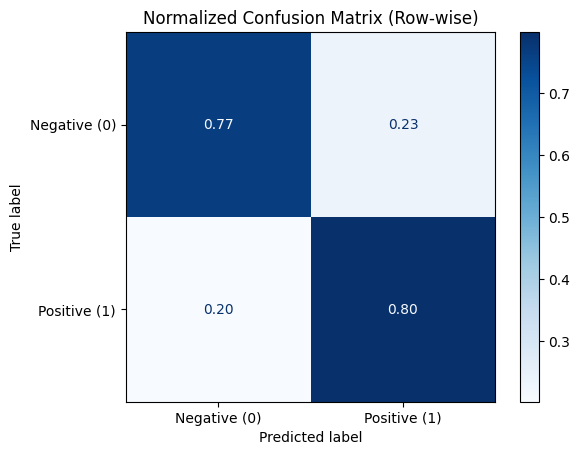

In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred, normalize="true")

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Negative (0)", "Positive (1)"]
)

disp.plot(values_format=".2f", cmap="Blues")
plt.title("Normalized Confusion Matrix (Row-wise)")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()
